In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 8
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_3"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| include: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("JuMP")
# Pkg.add("Ipopt")
# Pkg.add("Statistics")
# Pkg.add("Plots")
# Pkg.add("ForwardDiff")
# Pkg.add("LinearAlgebra")
# Pkg.add("LaTeXStrings")
# Pkg.add("GLM")
# Pkg.add("DataFrames")
# Pkg.add("Distributions")

  Activating project at `~/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_3`


In [3]:
β_b = [-1.0, -0.8,  0.1,  0.3, -0.2, -0.3];
β_t = [-0.6, -0.8,  0.2,  0.6, -0.1, -0.2]; 

In [4]:
N_survey = 200 # Individuals surveyed per city
N_nr_cities = 30 # Non-rail cities surveyed

30

In [5]:
using Random, Distributions, Statistics
Random.seed!(652)
density_nr = rand(Uniform(1, 8), N_nr_cities); # Thousands of people per square mile

In [6]:
busstops_nr = 5 .+ density_nr .* 6 .+ rand(Uniform(-3, 3), N_nr_cities) # 5 + 6 x density plus random variation
busstops_nr = round.(busstops_nr, digits = 0); # Make it an integer

In [7]:
price_nr = 100 .+ busstops_nr .* 15 .+ rand(Uniform(-50, 50), N_nr_cities); # 100 + 15 x stops plus random variation
price_nr = price_nr ./ 100; # Re-scale to hundreds of dollars

In [8]:
using DataFrames
cities_nr = DataFrame(
  city = ["nr_$(i)" for i in 1:N_nr_cities], # Create an index
  price_bus = price_nr,
  stops_bus = busstops_nr, 
  price_train = zeros(N_nr_cities), # No trains
  stops_train = zeros(N_nr_cities), # No trains
  density = density_nr
);
println(cities_nr[1:5,:]) # Look at first 5 rows

5×6 DataFrame
 Row │ city    price_bus  stops_bus  price_train  stops_train  density 
     │ String  Float64    Float64    Float64      Float64      Float64 
─────┼─────────────────────────────────────────────────────────────────
   1 │ nr_1      6.49054       36.0          0.0          0.0  5.30334
   2 │ nr_2      8.44181       49.0          0.0          0.0  7.70467
   3 │ nr_3      5.54409       32.0          0.0          0.0  4.35255
   4 │ nr_4      7.99252       44.0          0.0          0.0  6.29315
   5 │ nr_5      4.96632       27.0          0.0          0.0  4.07286


In [9]:
homeown_nr = rand(Bernoulli(0.75), N_survey * N_nr_cities);

In [10]:
hhsize_nr = rand(Poisson(3.0), N_survey * N_nr_cities);

In [11]:
survey_nr = DataFrame(
  city = repeat(["nr_$(i)" for i in 1:N_nr_cities], N_survey), # Create an index
  hhsize = hhsize_nr,
  homeown = homeown_nr
);

In [12]:
data_nr = leftjoin(survey_nr, cities_nr, on = :city);
println(data_nr[1:10,:]) # Look at first 10 rows

10×8 DataFrame
 Row │ city    hhsize  homeown  price_bus  stops_bus  price_train  stops_train  density  
     │ String  Int64   Bool     Float64?   Float64?   Float64?     Float64?     Float64? 
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │ nr_1         7    false    6.49054       36.0          0.0          0.0   5.30334
   2 │ nr_2         5     true    8.44181       49.0          0.0          0.0   7.70467
   3 │ nr_3         4     true    5.54409       32.0          0.0          0.0   4.35255
   4 │ nr_4         3    false    7.99252       44.0          0.0          0.0   6.29315
   5 │ nr_5         2     true    4.96632       27.0          0.0          0.0   4.07286
   6 │ nr_6         3     true    3.23068       18.0          0.0          0.0   2.42885
   7 │ nr_7         3    false    3.71792       17.0          0.0          0.0   1.87182
   8 │ nr_8         2    false    8.16212       50.0          0.0          0.0   7.32123
   

In [13]:
data_nr.V_ib = zeros(nrow(data_nr)) # Initialize V_{ib}
for i in 1:nrow(data_nr)
  # Get the corresponding row
  data_row = data_nr[i, [:price_bus, :stops_bus, :density, :hhsize, :homeown]]
  # Turn it into a numerical vector (adding the constant 1 in the first element)
  X_i = vcat(1.0, Vector{Float64}(data_row))

  # Calculate and store
  data_nr.V_ib[i] = X_i' * β_b;

end

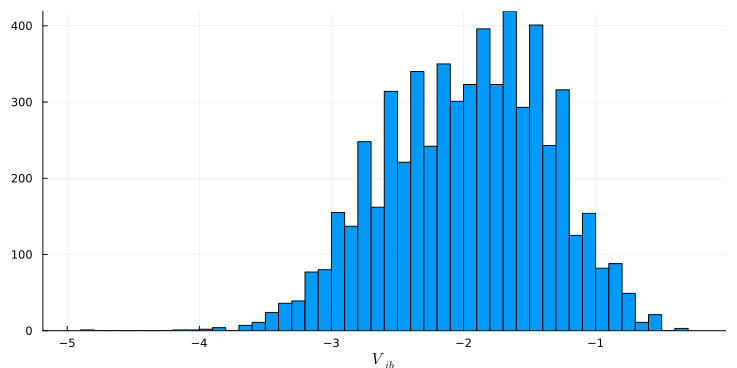

In [14]:
using Plots, LaTeXStrings
histogram(data_nr.V_ib, xlabel=L"V_{ib}", label="")

In [15]:
data_nr.ϵ_ib = rand(Logistic(0.0, 0.8), nrow(data_nr));
data_nr.ϵ_it = rand(Logistic(0.0, 0.8), nrow(data_nr));

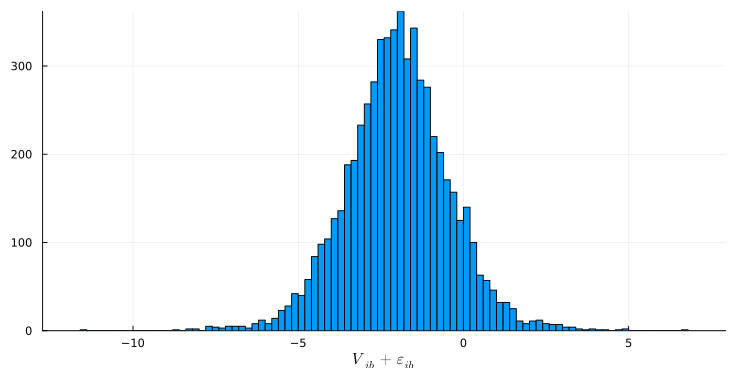

In [16]:
histogram(data_nr.V_ib .+ data_nr.ϵ_ib, xlabel=L"V_{ib} + \epsilon_{ib}", label="")

In [17]:
data_nr.d_ib = (data_nr.V_ib .+ data_nr.ϵ_ib .> 0.0); 
data_nr.d_it = zeros(nrow(data_nr)); # t is not available, so all zeros

In [18]:
sum(data_nr.d_ib)/nrow(data_nr)

0.09633333333333334

In [19]:
data_nr.V_it_hyp = zeros(nrow(data_nr)) # Initialize hypothetical V_{ib}
for i in 1:nrow(data_nr)
  # Get the corresponding row
  data_row = data_nr[i, [:price_bus, :stops_bus, :density, :hhsize, :homeown]]

# Turn it into a numerical vector (adding the constant 1 in the first element)
  X_i = vcat(1.0, Vector{Float64}(data_row))

  X_i[2] = 1.05 * X_i[2] # Increase in prices
  X_i[3] = 1.1 * X_i[3] # But with an increase in bus stops

  # Calculate and store
  data_nr.V_it_hyp[i] = X_i' * β_b;

end

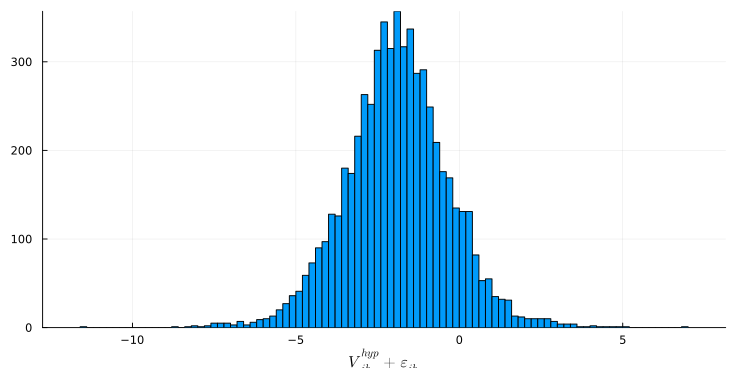

In [20]:
histogram(data_nr.V_it_hyp .+ data_nr.ϵ_ib, xlabel=L"V_{ib}^{hyp} + \epsilon_{ib}", label="")

In [21]:
data_nr.d_it_hyp = (data_nr.V_it_hyp .+ data_nr.ϵ_it .> 0.0) .& (data_nr.V_it_hyp .+ data_nr.ϵ_it .> data_nr.V_ib .+ data_nr.ϵ_ib); 

In [22]:
sum(data_nr.d_it_hyp)/nrow(data_nr)

0.09733333333333333

In [23]:
data_nr.d_ib_hyp = (data_nr.V_ib .+ data_nr.ϵ_ib .> 0.0) .& (data_nr.V_ib .+ data_nr.ϵ_ib .> data_nr.V_it_hyp .+ data_nr.ϵ_it); 

In [24]:
sum(data_nr.d_ib_hyp)/nrow(data_nr)

0.08883333333333333

In [25]:
N_r_cities = 30;

In [26]:
density_r = rand(Uniform(4, 12), N_r_cities); # Thousands of people per square mile

In [27]:
busstops_r = 5 .+ density_r .* 6 .+ rand(Uniform(-3, 3), N_r_cities) # 5 + 6 x density plus random variation
busstops_r = round.(busstops_r, digits = 0); # Make it an integer

busprice_r = 100 .+ busstops_r .* 15 .+ rand(Uniform(-50, 50), N_r_cities); # 100 + 15 x stops plus random variation
busprice_r = busprice_r ./ 100; # Re-scale to hundreds of dollars

In [28]:
trainstops_r = 3 .+ density_r .* 2 .+ rand(Uniform(0, 5), N_r_cities) 
trainstops_r = round.(trainstops_r, digits = 0); # Make it an integer

trainprice_r = busprice_r.*100 .+ trainstops_r .* 5 .+ rand(Uniform(0, 50), N_r_cities); # Should be more expensive than bus
trainprice_r = trainprice_r ./ 100; # Re-scale to hundreds of dollars

In [29]:
cities_r = DataFrame(
  city = ["r_$(i)" for i in 1:N_r_cities], # Create an index
  price_bus = price_nr,
  stops_bus = busstops_nr, 
  price_train = trainprice_r,
  stops_train = trainstops_r,
  density = density_nr
);
println(cities_r[1:5,:]) # Look at first 5 rows

5×6 DataFrame
 Row │ city    price_bus  stops_bus  price_train  stops_train  density 
     │ String  Float64    Float64    Float64      Float64      Float64 
─────┼─────────────────────────────────────────────────────────────────
   1 │ r_1       6.49054       36.0     10.9649          23.0  5.30334
   2 │ r_2       8.44181       49.0      7.26067         15.0  7.70467
   3 │ r_3       5.54409       32.0      7.23074         18.0  4.35255
   4 │ r_4       7.99252       44.0     13.5075          29.0  6.29315
   5 │ r_5       4.96632       27.0      6.98612         13.0  4.07286


In [30]:
homeown_r = rand(Bernoulli(0.50), N_survey * N_r_cities);

In [31]:
hhsize_r = rand(Poisson(2.5), N_survey * N_r_cities);

In [32]:
survey_r = DataFrame(
  city = repeat(["r_$(i)" for i in 1:N_r_cities], N_survey), # Create an index
  hhsize = hhsize_r,
  homeown = homeown_r
);

In [33]:
data_r = leftjoin(survey_r, cities_r, on = :city);
println(data_r[1:10,:]) # Look at first 10 rows

10×8 DataFrame
 Row │ city    hhsize  homeown  price_bus  stops_bus  price_train  stops_train  density  
     │ String  Int64   Bool     Float64?   Float64?   Float64?     Float64?     Float64? 
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │ r_1          2    false    6.49054       36.0     10.9649          23.0   5.30334
   2 │ r_2          0     true    8.44181       49.0      7.26067         15.0   7.70467
   3 │ r_3          2    false    5.54409       32.0      7.23074         18.0   4.35255
   4 │ r_4          2     true    7.99252       44.0     13.5075          29.0   6.29315
   5 │ r_5          2    false    4.96632       27.0      6.98612         13.0   4.07286
   6 │ r_6          1    false    3.23068       18.0      7.16408         15.0   2.42885
   7 │ r_7          1    false    3.71792       17.0      6.43189         13.0   1.87182
   8 │ r_8          2     true    8.16212       50.0     13.4608          28.0   7.32123
   

In [34]:
data_r.V_ib = zeros(nrow(data_r)) # Initialize V_{ib}
data_r.V_it = zeros(nrow(data_r)) # Initialize V_{ib}
for i in 1:nrow(data_r)
  # Get the corresponding row
  data_row_b = data_r[i, [:price_bus, :stops_bus, :density, :hhsize, :homeown]]
  # Turn it into a numerical vector (adding the constant 1 in the first element)
  X_ib = vcat(1.0, Vector{Float64}(data_row_b))
  # Calculate and store
  data_r.V_ib[i] = X_ib' * β_b;
  
  # Repeat for train
  data_row_t = data_r[i, [:price_train, :stops_train, :density, :hhsize, :homeown]]
  X_it = vcat(1.0, Vector{Float64}(data_row_t))
  # Calculate and store
  data_r.V_it[i] = X_it' * β_t;
end

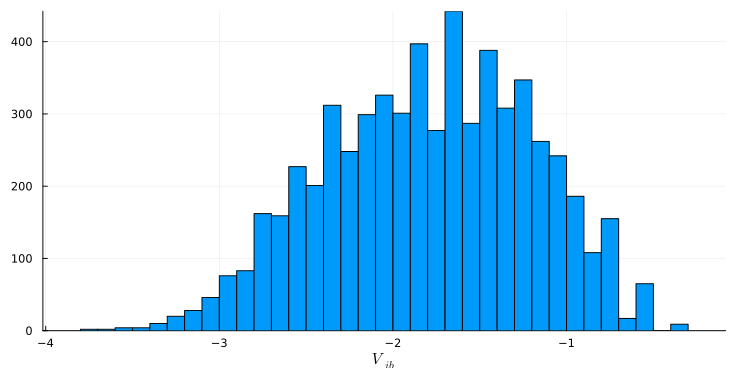

In [35]:
histogram(data_r.V_ib, xlabel=L"V_{ib}", label="")

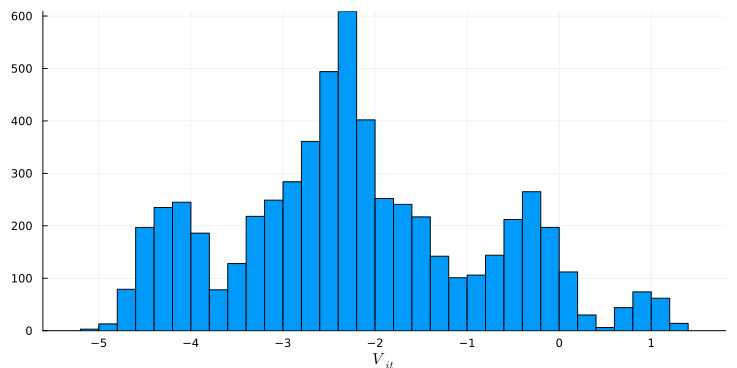

In [36]:
histogram(data_r.V_it, xlabel=L"V_{it}", label="")

In [37]:
data_r.ϵ_ib = rand(Logistic(0.0, 0.8), nrow(data_nr));
data_r.ϵ_it = rand(Logistic(0.0, 0.8), nrow(data_nr));

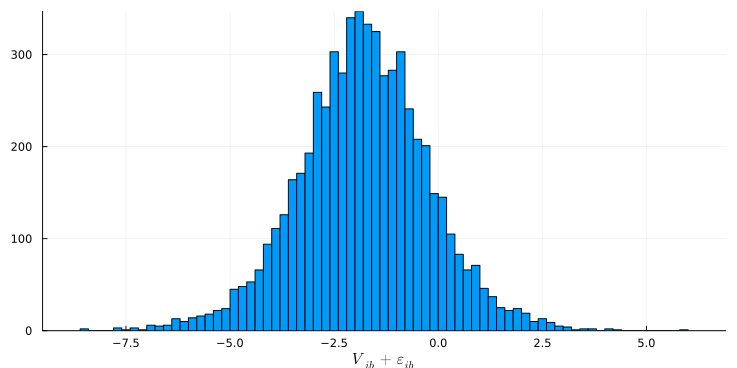

In [38]:
histogram(data_r.V_ib .+ data_r.ϵ_ib, xlabel=L"V_{ib} + \epsilon_{ib}", label="")

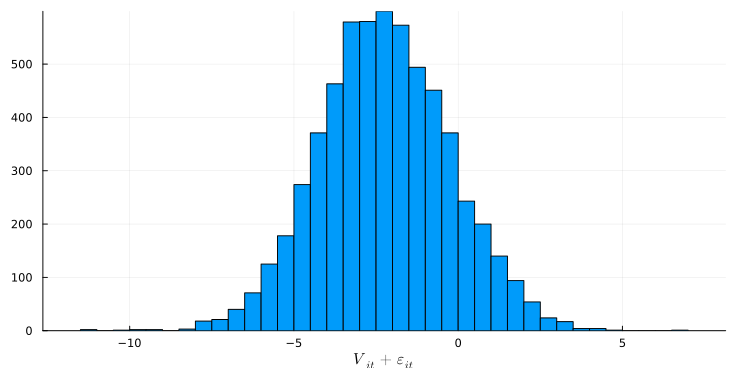

In [39]:
histogram(data_r.V_it .+ data_r.ϵ_it, xlabel=L"V_{it} + \epsilon_{it}", label="")

In [40]:
data_r.d_it = (data_r.V_it .+ data_r.ϵ_it .> 0.0) .& (data_r.V_it .+ data_r.ϵ_it .> data_r.V_ib .+ data_r.ϵ_ib); 

In [41]:
data_r.d_ib = (data_r.V_ib .+ data_r.ϵ_ib .> 0.0) .& (data_r.V_ib .+ data_r.ϵ_ib .> data_r.V_it .+ data_r.ϵ_it); 

In [42]:
sum(data_r.d_ib)/nrow(data_r)

0.1035

In [43]:
sum(data_r.d_it)/nrow(data_r)

0.12183333333333334